# Simulating Contact Tracing in Pandemic
#### **Non-Gaussian Process Based Experimentations**

This notebook contains sensitivity analysis experiments using non-Gaussian-process based approaches for understanding the effect of variables to COVID-19 spread rate in the UK.

In [ ]:
!git clone https://github.com/rs-delve/tti-explorer.git
%cd tti-explorer
%pip install -q .

Cloning into 'tti-explorer'...
remote: Enumerating objects: 554, done.
remote: Counting objects: 100% (554/554), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 2667 (delta 396), reused 405 (delta 277), pack-reused 2113
Receiving objects: 100% (2667/2667), 31.55 MiB | 15.51 MiB/s, done.
Resolving deltas: 100% (1909/1909), done.
/content/tti-explorer


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm
from IPython.display import display, HTML
from copy import deepcopy
import random

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

## Utilities

This section contains utility functions for experimentations.

In [ ]:
def print_doc(func):
    print(func.__doc__)

In [ ]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

In [ ]:
def do_simulation(policy_name, case_config, contacts_config, n_cases, random_state=None):
    # Prepare simulation configuration
    case_config = case_config
    contacts_config = contacts_config
    policy_config = config.get_strategy_configs("delve", policy_name)[policy_name]
    factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
    strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)

    # Initialise configuration model
    if random_state is None:
        rng = np.random.RandomState(random.randint(0, 1000))
    else:
        rng = np.random.RandomState(random_state)

    simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)
    tti_model = TTIFlowModel(rng, **strategy_config)

    # Aggregates all cases outputs
    outputs = list()

    # Perform simulation
    for _ in range(n_cases):
        case = simulate_case(rng, **case_config)
        case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
        contacts = simulate_contacts(case, **contacts_config)
        res = tti_model(case, contacts, case_factors)
        outputs.append(res)
    
    return outputs

In [ ]:
def summarise_simulation_results(outputs, policy_name, case_config):
    to_show = [
        RETURN_KEYS.base_r,
        RETURN_KEYS.reduced_r,
        RETURN_KEYS.man_trace,
        RETURN_KEYS.app_trace,
        RETURN_KEYS.tests
    ]

    # Scale factor to turn simulation numbers into UK population numbers
    nppl = case_config['infection_proportions']['nppl']
    scales = [1, 1, nppl, nppl, nppl]

    results = pd.DataFrame(
        outputs
    ).mean(
        0
    ).loc[
        to_show
    ].mul(
        scales
    ).to_frame(
        name=f"Simulation results: {policy_name.replace('_', ' ')}"
    ).rename(
        index=lambda x: x + " (k per day)" if x.startswith("#") else x
    )

    display(results.round(1))

## Configuration

This section contains configuration files that we will vary during experimentation.


#### Case Config
The following are configurations for each case:
- ```p_under18``` (float): probability of the case being under 18.
- ```infection_proportions``` (dict): probability of being *symp covid neg, symp covid pos, asymp covid pos*.
- ```p_day_noticed_symptoms``` (np.array[float]): distribution of day on which case notices their symptoms. (In our model this is the same as reporting symptoms.)
- ```inf_profile``` (list[float]): describe relative infectiousness of the case for each day of the infectious period. If covid=False, then the value is 0 throughout. We assume 10 days infectiousness following research paper regarding covid. 

In [ ]:
case_config = {
    'p_under18': 0.21, 
    'infection_proportions': {
        'dist': [0.8333333333333334, 0.1, 0.06666666666666667], 
        'nppl': 120
        }, 
    'p_day_noticed_symptoms': [0, 
                               0.25, 
                               0.25, 
                               0.2, 
                               0.1, 
                               0.05, 
                               0.05, 
                               0.05, 
                               0.05, 
                               0.0], 
    'inf_profile': [0.046966101377360424, 
                    0.15602255610429985, 
                    0.19829974712514023, 
                    0.18356485224565827, 
                    0.14541407040442172, 
                    0.10500447388376151, 
                    0.07130993362939089, 
                    0.04635772205156416, 
                    0.029167894888682697, 
                    0.017892648289720214]
    }

#### Contact Config

The following are configurations for each contact with a case:
- ```home_sar``` (float): secondary attack rate for household contacts. These contacts are infected at random with attack rates given by the SARs and whether or not the case is symptomatic. If the case is COVID negative, then no contacts are infected.
- ```work_sar``` (float): secondary attack rate for contacts in the work category.
- ```other_sar``` (float): secondary attack rate for contacts in the other category.
- ```asymp_factor``` (float): factor by which to multiply the probability of secondary infection if case is asymptomatic COVID positive (more dangerous).
- ```period``` (int): duration of the simulation (days).

In [ ]:
contacts_config = {
   'home_sar': 0.3, 
   'work_sar': 0.045, 
   'other_sar': 0.045, 
   'period': 10, 
   'asymp_factor': 0.5
   }

#### CaseFactors Config

The following are configurations for the factors:
- ```app_cov``` (float): coverage of people using the app.
- ```compliance``` (float): probability of a traced contact isolating correctly.
- ```go_to_school_prob``` (float): fraction of school children attending school.
- ```wfh_prob``` (float): proportion of the population working from home.

In [ ]:
factor_config = {
    'app_cov': 0.35, 
    'compliance': 0.8, 
    'go_to_school_prob': 0.5, 
    'wfh_prob': 0.45
    }

#### Policy Config

In [ ]:
policy_config = {
    isolate_individual_on_symptoms=True,  # Isolate the individual after they present with symptoms
    isolate_individual_on_positive=True,  # Isolate the individual after they test positive
    isolate_household_on_symptoms=False,  # Isolate the household after individual present with symptoms
    isolate_household_on_positive=True,  # Isolate the household after individual test positive
    isolate_contacts_on_symptoms=False,  # Isolate the contacts after individual present with symptoms
    isolate_contacts_on_positive=True,  # Isolate the contacts after individual test positive
    test_contacts_on_positive=False,  # Do we test contacts of a positive case immediately, or wait for them to develop symptoms
    do_symptom_testing=True,  # Test symptomatic individuals
    do_manual_tracing=True,  # Perform manual tracing of contacts
    do_app_tracing=True,  # Perform app tracing of contacts
    fractional_infections=True,  # Include infected but traced individuals as a fraction of their infection period not isolated
    testing_delay=2,  # Days delay between test and results
    app_trace_delay=0,  # Delay associated with tracing through the app
    manual_trace_delay=1,  # Delay associated with tracing manually
    manual_home_trace_prob=1.0,  # Probability of manually tracing a home contact
    manual_work_trace_prob=1.0,  # Probability of manually tracing a work contact
    manual_othr_trace_prob=1.0,  # Probability of manually tracing an other contact
    met_before_w=1.0,  # Probability of having met a work contact before to be able to manually trace
    met_before_s=1.0,  # Probability of having met a school contact before to be able to manually trace
    met_before_o=1.0,  # Probability of having met a other contact before to be able to manually trace
    max_contacts=2e3,  # Place a limit on the number of other contacts per day
    quarantine_length=14,  # Length of quarantine imposed on COVID cases (and household)
    latent_period=3,  # Length of a cases incubation period (from infection to start of infectious period)
    # Parameters for CaseFactors simulation
    app_cov=0.35,
    compliance=0.8,  # Probability of a traced contact isolating correctly
    go_to_school_prob=1.0,  # Fraction of school children attending school
    wfh_prob=0.0,  # Proportion or the population working from home
    }

#### Strategy Config

In [ ]:
strategy_config = {
    'isolate_individual_on_symptoms': True, 
    'isolate_individual_on_positive': True, 
    'isolate_household_on_symptoms': True, 
    'isolate_household_on_positive': True, 
    'isolate_contacts_on_symptoms': False, 
    'isolate_contacts_on_positive': True, 
    'test_contacts_on_positive': False, 
    'do_symptom_testing': True, 
    'do_manual_tracing': True, 
    'do_app_tracing': True, 
    'fractional_infections': True, 
    'testing_delay': 2, 
    'app_trace_delay': 0, 
    'manual_trace_delay': 1, 
    'manual_home_trace_prob': 1.0, 
    'manual_work_trace_prob': 1.0, 
    'manual_othr_trace_prob': 1.0, 
    'met_before_w': 0.79, 
    'met_before_s': 0.9, 
    'met_before_o': 0.9, 
    'max_contacts': 10, 
    'quarantine_length': 14, 
    'latent_period': 3, 
    'app_cov': 0.35, 
    'compliance': 0.8
    }

**Note**: for the case and contact config, we can vary with any values that we want. However, for the policy and strategy config, we select default options from combinations of *{S1, S2, S3, S4, S5}* and *{no_TTI, symptom_based_TTI, test_based_TTI, test_based_TTI_test_contacts}*.

As extension to the default, we can also vary some values on the policy and strategy config.

## Experimentations

In [ ]:
# Load data
path_to_bbc_data = os.path.join("data", "bbc-pandemic")

over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))

### Age

This section experiments the effect of varying the probability of case being under 18. We aim to see whether under 18 primary case infections is more fatal compared to over 18 primary case infections.

In [ ]:
policy_name = "S2_test_based_TTI"
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
n_experiments = 5 # number of simulations performed for a particular value

In [ ]:
p_under18_params = np.arange(11) / 10
dict_outputs = {p_under18: [] for p_under18 in p_under18_params}

In [ ]:
# Try all possible p_under18
for p_under18 in tqdm(p_under18_params):
    case_config_ = deepcopy(case_config)
    case_config_["p_under18"] = p_under18

    # For each case, experiment n times
    for _ in range(n_experiments):
        outputs = do_simulation(policy_name, case_config_, contacts_config, n_cases=10000)
        dict_outputs[p_under18].append(outputs)

In [ ]:
for p_under18 in p_under18_params:
    case_config_ = deepcopy(case_config)
    case_config_["p_under18"] = p_under18
    print("*"*20, f"p_under18 parameters: {p_under18}", "*"*20)
    for i in range(n_experiments):
        outputs = dict_outputs[p_under18][i]
        summarise_simulation_results(outputs, policy_name, case_config_)
    
    print("\n")

******************** p_under18 parameters: 0.0 ********************


,Simulation results: S2 test based TTI
Base R,4.1
Effective R,1.8
# Manual Traces (k per day),180.7
# App Traces (k per day),26.9
# Tests Needed (k per day),89.5


,Simulation results: S2 test based TTI
Base R,4.2
Effective R,1.8
# Manual Traces (k per day),187.9
# App Traces (k per day),32.1
# Tests Needed (k per day),89.8


,Simulation results: S2 test based TTI
Base R,4.1
Effective R,1.7
# Manual Traces (k per day),177.0
# App Traces (k per day),28.8
# Tests Needed (k per day),89.6


,Simulation results: S2 test based TTI
Base R,3.9
Effective R,1.8
# Manual Traces (k per day),181.6
# App Traces (k per day),31.7
# Tests Needed (k per day),88.8


,Simulation results: S2 test based TTI
Base R,4.1
Effective R,1.7
# Manual Traces (k per day),178.9
# App Traces (k per day),27.6
# Tests Needed (k per day),89.9




******************** p_under18 parameters: 0.1 ********************


,Simulation results: S2 test based TTI
Base R,3.8
Effective R,1.8
# Manual Traces (k per day),186.4
# App Traces (k per day),28.2
# Tests Needed (k per day),89.2


,Simulation results: S2 test based TTI
Base R,4.1
Effective R,1.7
# Manual Traces (k per day),186.7
# App Traces (k per day),26.6
# Tests Needed (k per day),89.2


,Simulation results: S2 test based TTI
Base R,4.0
Effective R,1.8
# Manual Traces (k per day),186.1
# App Traces (k per day),28.7
# Tests Needed (k per day),89.4


,Simulation results: S2 test based TTI
Base R,3.9
Effective R,1.8
# Manual Traces (k per day),170.3
# App Traces (k per day),24.0
# Tests Needed (k per day),90.1


,Simulation results: S2 test based TTI
Base R,4.1
Effective R,1.9
# Manual Traces (k per day),199.3
# App Traces (k per day),29.3
# Tests Needed (k per day),90.1




******************** p_under18 parameters: 0.2 ********************


,Simulation results: S2 test based TTI
Base R,3.9
Effective R,1.7
# Manual Traces (k per day),190.8
# App Traces (k per day),30.8
# Tests Needed (k per day),88.8


,Simulation results: S2 test based TTI
Base R,3.9
Effective R,1.8
# Manual Traces (k per day),170.4
# App Traces (k per day),28.8
# Tests Needed (k per day),89.8


,Simulation results: S2 test based TTI
Base R,4.1
Effective R,1.8
# Manual Traces (k per day),165.1
# App Traces (k per day),23.0
# Tests Needed (k per day),90.3


,Simulation results: S2 test based TTI
Base R,3.8
Effective R,1.7
# Manual Traces (k per day),188.0
# App Traces (k per day),30.5
# Tests Needed (k per day),89.7


,Simulation results: S2 test based TTI
Base R,3.8
Effective R,1.8
# Manual Traces (k per day),161.1
# App Traces (k per day),26.5
# Tests Needed (k per day),89.3




******************** p_under18 parameters: 0.3 ********************


,Simulation results: S2 test based TTI
Base R,3.7
Effective R,1.7
# Manual Traces (k per day),186.7
# App Traces (k per day),28.5
# Tests Needed (k per day),89.3


,Simulation results: S2 test based TTI
Base R,3.9
Effective R,1.8
# Manual Traces (k per day),187.1
# App Traces (k per day),28.6
# Tests Needed (k per day),89.3


,Simulation results: S2 test based TTI
Base R,3.8
Effective R,1.7
# Manual Traces (k per day),185.1
# App Traces (k per day),31.3
# Tests Needed (k per day),89.7


,Simulation results: S2 test based TTI
Base R,3.7
Effective R,1.6
# Manual Traces (k per day),175.8
# App Traces (k per day),31.6
# Tests Needed (k per day),89.4


,Simulation results: S2 test based TTI
Base R,3.7
Effective R,1.6
# Manual Traces (k per day),175.8
# App Traces (k per day),31.6
# Tests Needed (k per day),89.4




******************** p_under18 parameters: 0.4 ********************


,Simulation results: S2 test based TTI
Base R,3.9
Effective R,1.8
# Manual Traces (k per day),191.3
# App Traces (k per day),27.7
# Tests Needed (k per day),90.0


,Simulation results: S2 test based TTI
Base R,3.7
Effective R,1.8
# Manual Traces (k per day),171.6
# App Traces (k per day),24.1
# Tests Needed (k per day),89.6


,Simulation results: S2 test based TTI
Base R,3.9
Effective R,1.7
# Manual Traces (k per day),202.1
# App Traces (k per day),34.8
# Tests Needed (k per day),89.5


,Simulation results: S2 test based TTI
Base R,3.8
Effective R,1.8
# Manual Traces (k per day),192.7
# App Traces (k per day),31.0
# Tests Needed (k per day),89.5


,Simulation results: S2 test based TTI
Base R,3.7
Effective R,1.7
# Manual Traces (k per day),183.3
# App Traces (k per day),28.1
# Tests Needed (k per day),89.4




******************** p_under18 parameters: 0.5 ********************


,Simulation results: S2 test based TTI
Base R,3.5
Effective R,1.6
# Manual Traces (k per day),177.7
# App Traces (k per day),24.0
# Tests Needed (k per day),88.8


,Simulation results: S2 test based TTI
Base R,3.4
Effective R,1.5
# Manual Traces (k per day),167.5
# App Traces (k per day),30.8
# Tests Needed (k per day),90.1


,Simulation results: S2 test based TTI
Base R,3.5
Effective R,1.6
# Manual Traces (k per day),189.7
# App Traces (k per day),28.5
# Tests Needed (k per day),90.6


,Simulation results: S2 test based TTI
Base R,3.9
Effective R,1.7
# Manual Traces (k per day),204.1
# App Traces (k per day),24.3
# Tests Needed (k per day),89.4


,Simulation results: S2 test based TTI
Base R,3.5
Effective R,1.7
# Manual Traces (k per day),157.5
# App Traces (k per day),19.5
# Tests Needed (k per day),89.3




******************** p_under18 parameters: 0.6 ********************


,Simulation results: S2 test based TTI
Base R,3.6
Effective R,1.7
# Manual Traces (k per day),171.2
# App Traces (k per day),21.6
# Tests Needed (k per day),88.5


,Simulation results: S2 test based TTI
Base R,3.6
Effective R,1.7
# Manual Traces (k per day),181.3
# App Traces (k per day),26.6
# Tests Needed (k per day),89.3


,Simulation results: S2 test based TTI
Base R,3.5
Effective R,1.6
# Manual Traces (k per day),162.2
# App Traces (k per day),26.6
# Tests Needed (k per day),88.4


,Simulation results: S2 test based TTI
Base R,3.3
Effective R,1.5
# Manual Traces (k per day),162.1
# App Traces (k per day),27.9
# Tests Needed (k per day),89.3


,Simulation results: S2 test based TTI
Base R,3.5
Effective R,1.6
# Manual Traces (k per day),180.5
# App Traces (k per day),23.4
# Tests Needed (k per day),90.4




******************** p_under18 parameters: 0.7 ********************


,Simulation results: S2 test based TTI
Base R,3.3
Effective R,1.6
# Manual Traces (k per day),179.7
# App Traces (k per day),31.7
# Tests Needed (k per day),90.1


,Simulation results: S2 test based TTI
Base R,3.4
Effective R,1.7
# Manual Traces (k per day),170.1
# App Traces (k per day),25.6
# Tests Needed (k per day),89.4


,Simulation results: S2 test based TTI
Base R,3.5
Effective R,1.5
# Manual Traces (k per day),186.2
# App Traces (k per day),30.0
# Tests Needed (k per day),90.5


,Simulation results: S2 test based TTI
Base R,3.3
Effective R,1.5
# Manual Traces (k per day),180.2
# App Traces (k per day),30.5
# Tests Needed (k per day),89.5


,Simulation results: S2 test based TTI
Base R,3.4
Effective R,1.7
# Manual Traces (k per day),163.0
# App Traces (k per day),23.7
# Tests Needed (k per day),90.2




******************** p_under18 parameters: 0.8 ********************


,Simulation results: S2 test based TTI
Base R,3.7
Effective R,1.7
# Manual Traces (k per day),183.0
# App Traces (k per day),31.2
# Tests Needed (k per day),89.6


,Simulation results: S2 test based TTI
Base R,3.3
Effective R,1.6
# Manual Traces (k per day),193.8
# App Traces (k per day),25.5
# Tests Needed (k per day),88.8


,Simulation results: S2 test based TTI
Base R,3.3
Effective R,1.6
# Manual Traces (k per day),199.3
# App Traces (k per day),28.9
# Tests Needed (k per day),88.5


,Simulation results: S2 test based TTI
Base R,3.5
Effective R,1.7
# Manual Traces (k per day),193.6
# App Traces (k per day),26.4
# Tests Needed (k per day),88.9


,Simulation results: S2 test based TTI
Base R,3.5
Effective R,1.7
# Manual Traces (k per day),194.9
# App Traces (k per day),22.3
# Tests Needed (k per day),89.5




******************** p_under18 parameters: 0.9 ********************


,Simulation results: S2 test based TTI
Base R,3.3
Effective R,1.6
# Manual Traces (k per day),184.5
# App Traces (k per day),25.7
# Tests Needed (k per day),89.5


,Simulation results: S2 test based TTI
Base R,3.4
Effective R,1.6
# Manual Traces (k per day),169.2
# App Traces (k per day),26.8
# Tests Needed (k per day),90.2


,Simulation results: S2 test based TTI
Base R,3.2
Effective R,1.6
# Manual Traces (k per day),168.2
# App Traces (k per day),25.1
# Tests Needed (k per day),89.3


,Simulation results: S2 test based TTI
Base R,3.1
Effective R,1.6
# Manual Traces (k per day),158.9
# App Traces (k per day),23.7
# Tests Needed (k per day),88.5


,Simulation results: S2 test based TTI
Base R,3.3
Effective R,1.5
# Manual Traces (k per day),177.1
# App Traces (k per day),22.3
# Tests Needed (k per day),89.5




******************** p_under18 parameters: 1.0 ********************


,Simulation results: S2 test based TTI
Base R,3.2
Effective R,1.6
# Manual Traces (k per day),175.1
# App Traces (k per day),29.0
# Tests Needed (k per day),88.6


,Simulation results: S2 test based TTI
Base R,3.2
Effective R,1.6
# Manual Traces (k per day),191.1
# App Traces (k per day),23.2
# Tests Needed (k per day),90.3


,Simulation results: S2 test based TTI
Base R,3.2
Effective R,1.6
# Manual Traces (k per day),163.9
# App Traces (k per day),25.9
# Tests Needed (k per day),88.4


,Simulation results: S2 test based TTI
Base R,3.4
Effective R,1.7
# Manual Traces (k per day),161.7
# App Traces (k per day),21.6
# Tests Needed (k per day),89.5


,Simulation results: S2 test based TTI
Base R,3.2
Effective R,1.7
# Manual Traces (k per day),171.5
# App Traces (k per day),27.6
# Tests Needed (k per day),90.5


### Policy and Strategy

In [ ]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
policy_name_params.append("S0")
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
n_experiments = 5 # number of simulations performed for a particular value

In [ ]:
dict_outputs = {policy_name: [] for policy_name in policy_name_params}

In [ ]:
# Try all possible p_under18
for policy_name in tqdm(policy_name_params):
    # For each case, experiment n times
    for _ in range(n_experiments):
        outputs = do_simulation(policy_name, case_config_, contacts_config, n_cases=10000)
        dict_outputs[policy_name].append(outputs)

In [ ]:
for policy_name in policy_name_params:
    print("*"*20, f"policy name parameters: {policy_name}", "*"*20)
    for i in range(n_experiments):
        outputs = dict_outputs[policy_name][i]
        summarise_simulation_results(outputs, policy_name, case_config)
    
    print("\n")

In [ ]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
key_params.append("S0")
df_result = {"strategy": [], "gov_policy": [], "effective_r": [], "base_r": [],
             "manual_traces": [], "app_traces": [], "test_needed": []}
nppl = 120

for key in key_params:
    if key != "S0":
        strategy = key[:2]
        gov_policy = key[3:]
        
        for i in range(n_experiments):
            result_format = pd.DataFrame(dict_outputs[key][i]).mean(0)

            df_result["strategy"].append(strategy)
            df_result["gov_policy"].append(gov_policy)
            df_result["effective_r"].append(result_format.loc["Effective R"])
            df_result["base_r"].append(result_format.loc["Base R"])
            df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
            df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
            df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)

In [ ]:
df_result = pd.DataFrame(df_result)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set_style("ticks", rc={'axes.grid': True, 'xtick.direction': 'in'})

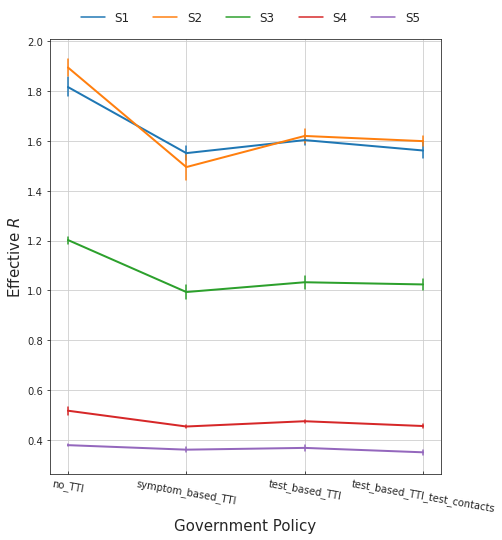

In [ ]:
fig = plt.figure(figsize=(7, 8))
ax = fig.add_subplot(111)

sns.lineplot(x="gov_policy", y="effective_r", data=df_result, hue="strategy", 
             err_style="bars", linewidth=2,
             ci=68)
sns.despine(top=False, right=False, left=False, bottom=False)
ax.legend(loc='center left', bbox_to_anchor=(0.05, 1.05), ncol=5, frameon=False,
          prop={'size': 12})
plt.ylabel("Effective $R$", fontsize=15)
plt.xlabel("Government Policy", fontsize=15)
plt.xticks(rotation=-10)
plt.show()

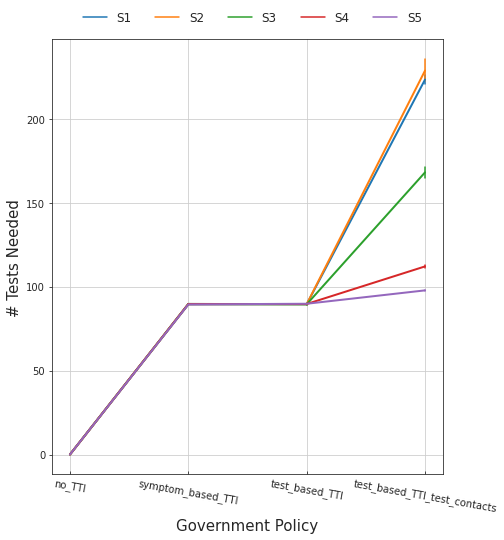

In [ ]:
fig = plt.figure(figsize=(7, 8))
ax = fig.add_subplot(111)

sns.lineplot(x="gov_policy", y="test_needed", data=df_result, hue="strategy", 
             err_style="bars", linewidth=2,
             ci=68)
sns.despine(top=False, right=False, left=False, bottom=False)
ax.legend(loc='center left', bbox_to_anchor=(0.05, 1.05), ncol=5, frameon=False,
          prop={'size': 12})
plt.ylabel("# Tests Needed", fontsize=15)
plt.xlabel("Government Policy", fontsize=15)
plt.xticks(rotation=-10)
plt.show()

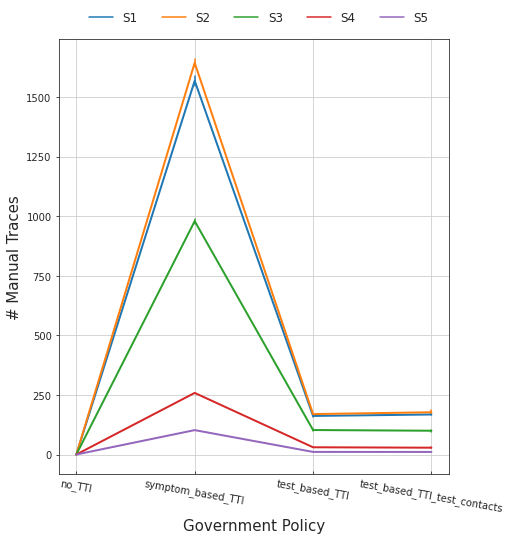

In [ ]:
fig = plt.figure(figsize=(7, 8))
ax = fig.add_subplot(111)

sns.lineplot(x="gov_policy", y="manual_traces", data=df_result, hue="strategy", 
             err_style="bars", linewidth=2,
             ci=68)
sns.despine(top=False, right=False, left=False, bottom=False)
ax.legend(loc='center left', bbox_to_anchor=(0.05, 1.05), ncol=5, frameon=False,
          prop={'size': 12})
plt.ylabel("# Manual Traces", fontsize=15)
plt.xlabel("Government Policy", fontsize=15)
plt.xticks(rotation=-10)
plt.show()

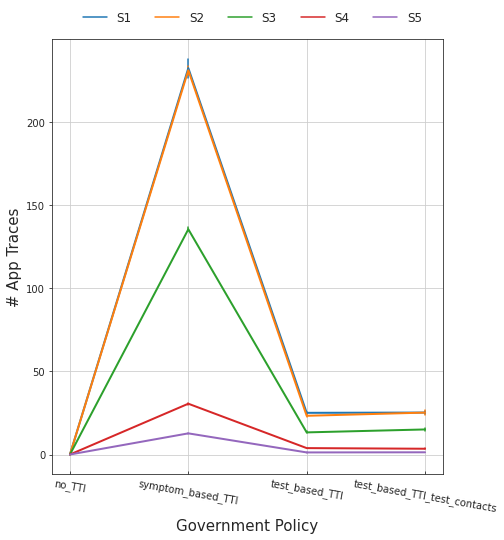

In [ ]:
fig = plt.figure(figsize=(7, 8))
ax = fig.add_subplot(111)

sns.lineplot(x="gov_policy", y="app_traces", data=df_result, hue="strategy", 
             err_style="bars", linewidth=2,
             ci=68)
sns.despine(top=False, right=False, left=False, bottom=False)
ax.legend(loc='center left', bbox_to_anchor=(0.05, 1.05), ncol=5, frameon=False,
          prop={'size': 12})
plt.ylabel("# App Traces", fontsize=15)
plt.xlabel("Government Policy", fontsize=15)
plt.xticks(rotation=-10)
plt.show()